<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Знакомство с данными</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Анализ-бизнес-метрик" data-toc-modified-id="Анализ-бизнес-метрик-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ бизнес метрик</a></span><ul class="toc-item"><li><span><a href="#Расходы" data-toc-modified-id="Расходы-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Расходы</a></span></li><li><span><a href="#Окупаемость" data-toc-modified-id="Окупаемость-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Окупаемость</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# BPA. Procrastinate Pro+, Inc.

В данном проекте мы проведем анализ развлекательного приложения Procrastinate Pro+.

###### Задача

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

###### Данные

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

###### Цели

Предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

###### Библиотеки

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# увеличим дефолтные настройки графиков
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6

###### Функции

In [2]:
# знакомство с таблицами
def description(df):
    print('Первые 5 строк таблицы:')
    display(df.head())
    print('\nИнформация о таблице:')
    display(df.info())
    print('\nДублицаты таблицы:')
    display(df[df.duplicated()])
    return None


# колонки к snake_case
def snake_cols(df):
    df.columns = df.columns.str.lower()
    df.columns = ['_'.join(x) for x in df.columns.str.split(' ')] # как называется этот трюк? я уже и не вспомню где его видел, а реализовал по чуйке
    return None


# кради как аналитик
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

# функция для визуализации LTV и ROI


def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(15, 9))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(10, 4))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(10, 7))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        ), fontsize=10
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        ), fontsize=10
    )
    
    plt.tight_layout()
    plt.show()

## Знакомство с данными

В нашем распоряжении три датасета. Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о покупках, а `costs_info_short.csv` — информацию о расходах на рекламу.

Структура `visits_info_short.csv`
- **User Id** — уникальный идентификатор пользователя,
- **Region** — страна пользователя,
- **Device** — тип устройства пользователя,
- **Channel** — идентификатор источника перехода,
- **Session Start** — дата и время начала сессии,
- **Session End** — дата и время окончания сессии.

Структура `orders_info_short.csv`
- **User Id** — уникальный идентификатор пользователя,
- **Event Dt** — дата и время покупки,
- **Revenue** — сумма заказа.

Структура `costs_info_short.csv`
- **Channel** — идентификатор рекламного источника,
- **Dt** — дата проведения рекламной кампании,
- **Costs** — расходы на эту кампанию.

*Импортируем эти данные и познакомимся с содержимым*

In [3]:
try:
    visits = pd.read_csv('jct/visits_info_short.csv')
    orders = pd.read_csv('jct/orders_info_short.csv')
    costs = pd.read_csv('jct/costs_info_short.csv')
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

In [4]:
description(visits)

Первые 5 строк таблицы:


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None


Дублицаты таблицы:


,User Id,Region,Device,Channel,Session Start,Session End


In [5]:
description(orders)

Первые 5 строк таблицы:


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None


Дублицаты таблицы:


,User Id,Event Dt,Revenue


In [6]:
description(costs)

Первые 5 строк таблицы:


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None


Дублицаты таблицы:


,dt,Channel,costs


***В таблицах нет дубликатов, но стоит преобразовать данные о датах и привести названия столбцов к snake_case***

In [7]:
# преобразуем столбцы к snake_case
snake_cols(visits)
snake_cols(costs)
snake_cols(orders)

# преобразуем даты к datetime
visits.session_start = pd.to_datetime(visits.session_start)
visits.session_end = pd.to_datetime(visits.session_start)
costs.dt = pd.to_datetime(costs.dt).dt.date
orders.event_dt = pd.to_datetime(orders.event_dt)

# проверим результат
print('visits:')
visits.info()
print('\norders:')
orders.info()
print('\ncosts:')
costs.info()

visits:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB

orders:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
m

Преобразование успешно.

## Исследовательский анализ данных

Для начала изучим профили пользователей платящих и неплатящих - из каких стран они приходят, из каких источников и какими устройствами пользуются.

Создаем таблицу профилей пользователей

In [8]:
profiles = get_profiles(visits, orders, None, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [9]:
profiles.dt.min()

datetime.date(2019, 5, 1)

In [10]:
profiles.dt.max()

datetime.date(2019, 10, 27)

In [11]:
visits.session_end.max()

Timestamp('2019-10-31 23:59:23')

Данные ограничены периодом привлечения пользователей с 1 Мая 2019 по 27 Октября 2019 годов, как и указано в описании данных.

Посмотрим из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.

In [12]:
profiles.groupby('region').agg(users=('user_id','count'),
                               payers_rate=('payer','mean'))\
                          .sort_values(by='payers_rate', ascending=False)

,users,payers_rate
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


Главный рынок компании - США на них приходится две трети всех пользователей а конверсия в покупателя составляет 6,9% против 4% в других странах.

Проверим распределение по устройствам

In [13]:
profiles.groupby('device').agg(users=('user_id','count'),
                               payers_rate=('payer','mean'))\
                          .sort_values(by='payers_rate', ascending=False).style.format({'payers_rate': '{:.2%}'})

,users,payers_rate
device,,
Mac,30042,6.36%
iPhone,54479,6.21%
Android,35032,5.85%
PC,30455,5.05%


Больше всего пользователей айфона, а наименьшая конверсия у пользователей ПК.

Распределение по каналу привлечения

In [14]:
profiles.groupby('channel').agg(users=('user_id','count'),
                               payers_rate=('payer','mean'))\
                          .sort_values(by='payers_rate', ascending=False).style.format({'payers_rate': '{:.2%}'})

,users,payers_rate
channel,,
FaceBoom,29144,12.20%
AdNonSense,3880,11.34%
lambdaMediaAds,2149,10.47%
TipTop,19561,9.60%
RocketSuperAds,4448,7.91%
WahooNetBanner,8553,5.30%
YRabbit,4312,3.83%
MediaTornado,4364,3.57%
LeapBob,8553,3.06%


Существуют как каналы с высокой конверсией, так и с очень низкой приближающейся к конверсии органического пользователя, что очень странно, возможно в этих каналах плохо настроен таргетинг, но делать выводы еще рано, надо смотреть на графики и стоимость привлечения.
<p></p>

###### EDA. Выводы:

- Главный рынок компании - США на них приходится две трети всех пользователей а конверсия в покупателя составляет 6,9% против 4% в других странах.
- Больше всего пользователей айфонов, а наименьшая конверсия у пользователей ПК.
- Есть группа каналов с низкой конверсией в покупателей, это возможные точки роста, вероятно там неверно настроен таргетинг. Наиболее весомые каналы это FaceBoom и TipTop. FaceBoom также лидер по конверсии.

## Анализ бизнес метрик

### Расходы

Рассмотрим как меняются расходы на маркетинг

In [15]:
costs.costs.sum()

105497.30000000002

Общие расходы - 105497

In [16]:
channel_costs = costs.groupby('channel').agg(costs=('costs', 'sum')).sort_values('costs', ascending=False)
channel_costs

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


TipTop и FaceBoom ожидаемо на первых строчках по затратам, т.к. объемы привлеченных пользователей у них кратно больше, чем у остальных источников. Их вклад в маркетинговые расходы около 80%.

Посмотрим как изменились расходы на рекламу во времени

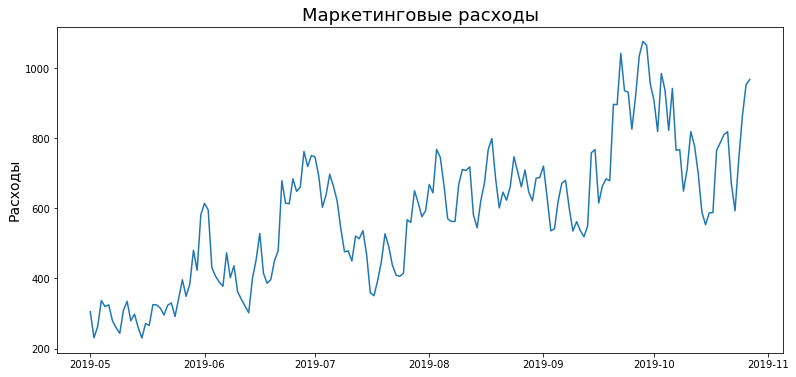

In [17]:
costs.groupby('dt').agg(costs=('costs', 'sum')).sort_values('costs', ascending=False).plot(legend=False)
plt.title(f'Маркетинговые расходы', fontsize=18)
plt.ylabel('Расходы', fontsize=14)
plt.xlabel(None)
plt.show()

Расходы на маркетинг постоянно растут и за полгода выросли в 3 раза. Также ли обстоит дело с доходами от него? И кто именно обходится нам дорого?

Проверим сколько в среднем стоило привлечение одного пользователя.

In [18]:
round(profiles.query('channel in @channel_costs.index').acquisition_cost.mean(), 2)

1.13

И для каждого источника

In [19]:
profiles.groupby('channel').agg(costs=('acquisition_cost', 'mean')).sort_values('costs', ascending=False)

,costs
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


TipTop значительно превосходит другие источники по цене, но он также формирует значительную часть клиентского потока. Но стоит ли оно того? Предстоит выяснить в следующем пункте анализа.

###### Анализ расходов. Выводы:

- Расходы на маркетинг растут постоянно, за полгода они выросли в 3 раза.
- Главные источники расходов - каналы TipTop и FaceBoom. В то же время они главные источники рекламных клиентов.
- Эти же каналы привлекают самых дорогостоящих клиентов, причем TipTop за цену втрое большую, чем у ближайшего конкурента.

### Окупаемость

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Примем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Здесь и ниже при анализе стоит исключать органический трафик, мы не платим за этих пользователей, а доход от них может завышать довольно плачевную картину и скрыть от нас проблемы в какой-то стране или же типе устройств.

In [20]:
paid_profiles = profiles.query('channel in @channel_costs.index')

Сначала проанализируем общую окупаемость рекламы

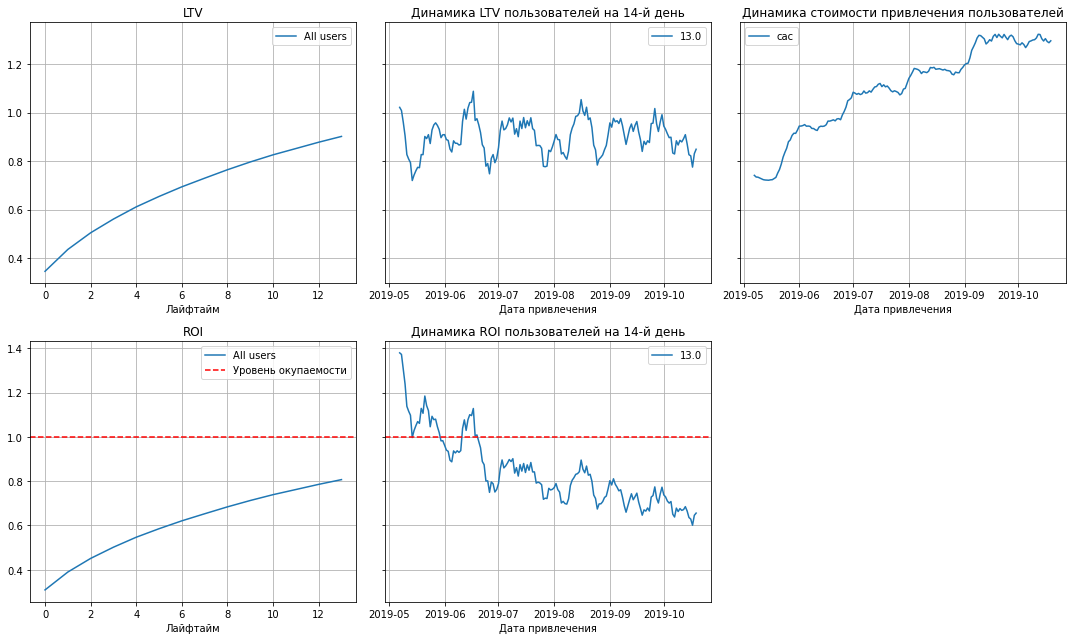

In [21]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

raw, ltv, ltv_history, roi, roi_history = get_ltv(paid_profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

ROI динамично снижается из-за повышения CAC. LTV показывает стабильность. Возможно проблема в некоторых каналах, рассмотрим динамику более подробно.

In [22]:
# на одном графике все каналы не поместятся, поэтому рассмотрим лидеров и аутсайдеров по расходам на канал отдельно
head_chanels = channel_costs.head().index
tail_chanels = channel_costs.tail().index

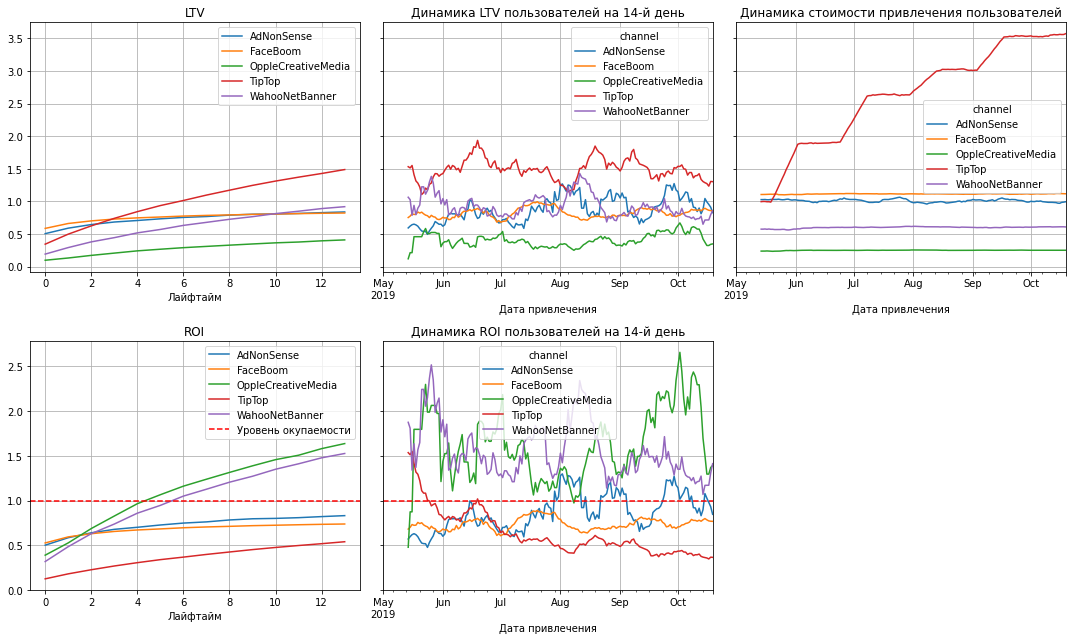

In [23]:
raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel in @head_chanels'),
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

In [24]:
channel_costs

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


TipTop, FaceBoom, AdNonSense - три убыточных канала привлечения, их главное отличие это высокий CAC относительно других каналов, что явно за границей зоны ответственности компании. Если их убыточность заключается только в этом, то единственный выход - это уход из этих каналов. Кроме того эти каналы в общей массе составляют около 85% рекламных расходов.

Примечателен TipTop высоким качеством клиентов, но постоянный рост стоимости привлечения делает его все менее и менее привлекательным.

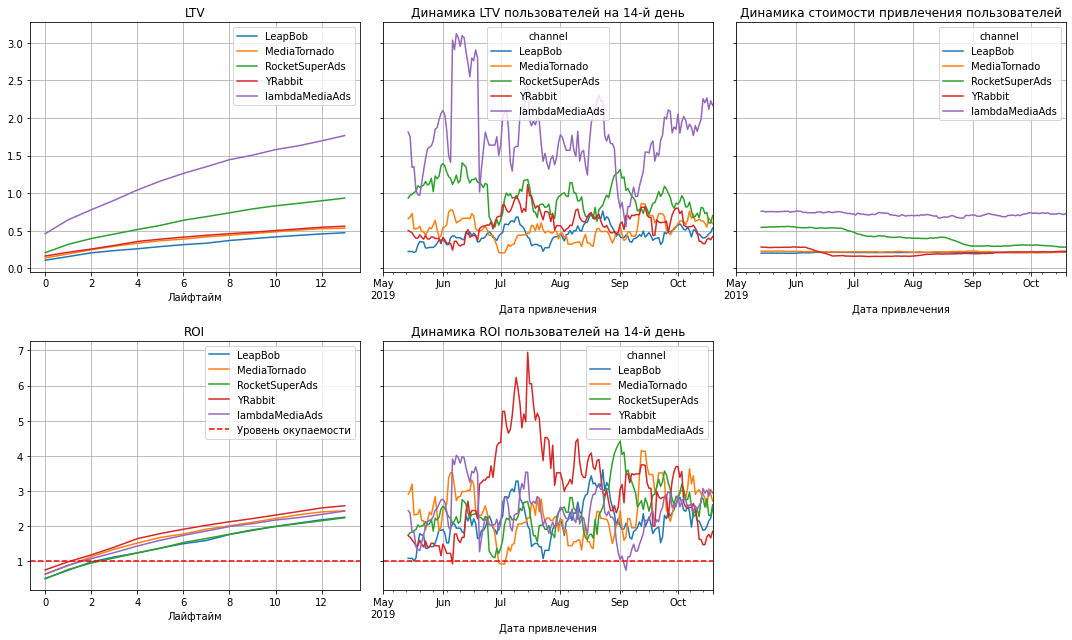

In [25]:
raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel in @tail_chanels'),
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Остальные каналы показывают хорошие результаты.

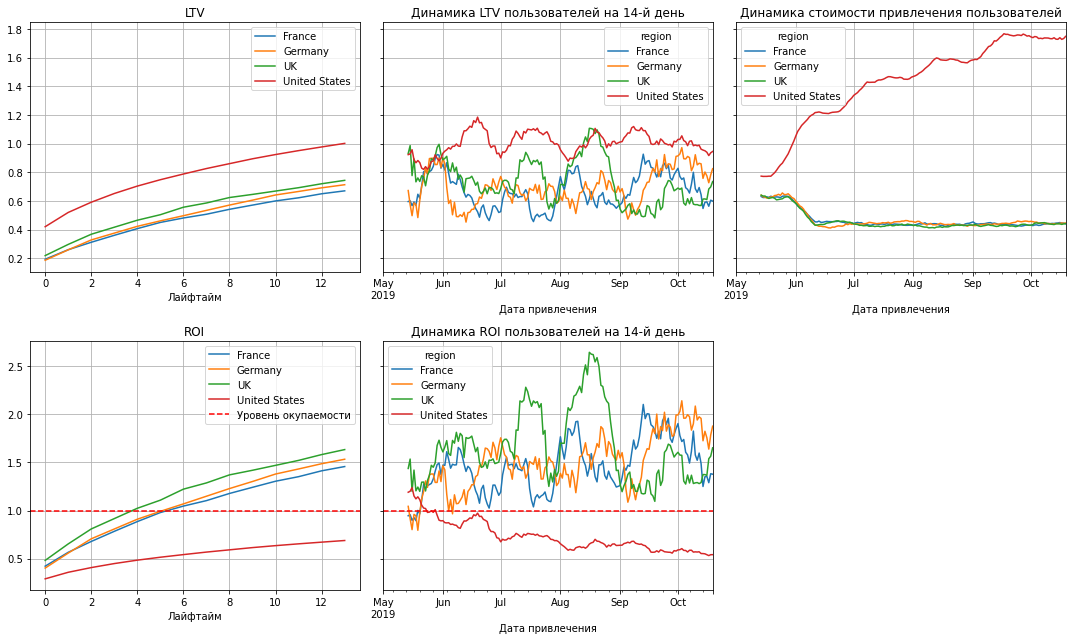

In [26]:
raw, ltv, ltv_history, roi, roi_history = get_ltv(
    paid_profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Больше всего денег приносит США, но стоимость клиента там настолько высока, что они забирают деньги с других рынков. Возможно убыточные каналы как-то связаны с рынком США.

In [27]:
check = profiles.copy()
check['is_us'] = check.region == 'United States'
check.groupby('channel').agg({'is_us': 'mean'}).style.format({'is_us': '{:.2%}'})

,is_us
channel,
AdNonSense,0.00%
FaceBoom,100.00%
LeapBob,0.00%
MediaTornado,100.00%
OppleCreativeMedia,0.00%
RocketSuperAds,100.00%
TipTop,100.00%
WahooNetBanner,0.00%
YRabbit,100.00%


- Есть исключительно американские каналы привлечения и главные проблемные в их числе.
- TipTop, FaceBoom - каналы, которые составляют около 80% рекламных расходов, они убыточны и принадлежат рынку США.
- MediaTornado, RocketSuperAds, YRabbit - прибыльные каналы, которым уделено печально мало внимания и денег. Особенно RocketSuperAds, который показал высокое качество привлеченных клиентов.

Проверим как меняются метрики в зависимости от устройства

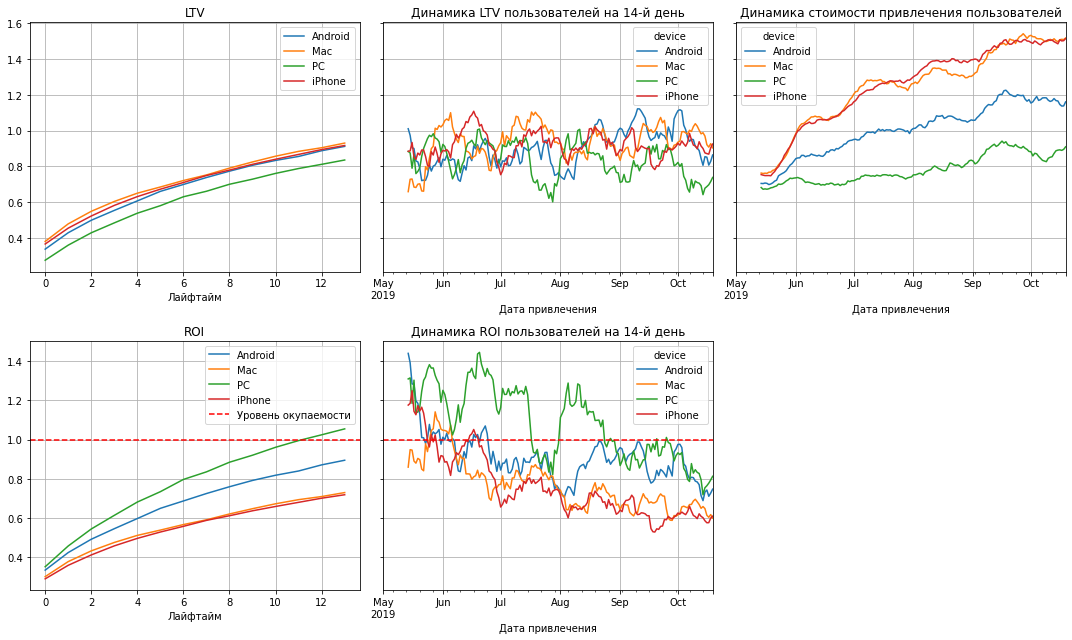

In [28]:
raw, ltv, ltv_history, roi, roi_history = get_ltv(
    paid_profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

- пользователи всех устройств на данный момент убыточны
- по динамике ROI и CAC, видно, что тендецния характерна для всех групп, следовательно вид устройства не имеет решающей роли в окупаемости клиента. Проблема в другом.

Главной проблемой являются каналы TipTop, FaceBoom. Можно ли как-либо компенсировать их за счет повышения конверсии или удержания.

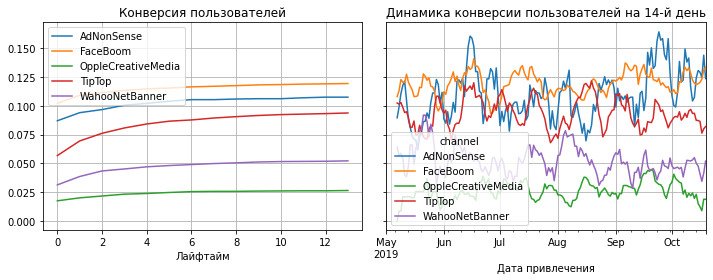

In [29]:
raw, conversion, conversion_history = get_conversion(
    profiles.query('channel in @head_chanels'),
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel']
)

plot_conversion(conversion, conversion_history, horizon_days, window=7)

TipTop, FaceBoom обладают хорошими показателями конверсии, тут вряд ли их можно как-то улучшить.

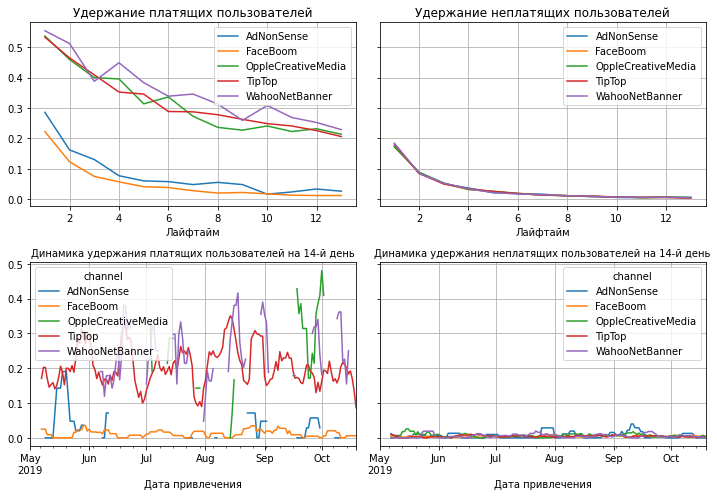

In [30]:
raw, retention, retention_history = get_retention(
    profiles.query('channel in @head_chanels'),
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel']
)

plot_retention(retention, retention_history, horizon_days, window=7)

- TipTop - канал с лучшим удержанием, к сожалению его главная проблема в дороговизне и с этим ничего нельзя поделать.
- FaceBoom - низкие показатели удержания, от этого канала лучше не отказывать, а попробовать найти способ повысить метрику.

Проверим TipTop на горизонте в 2 месяца

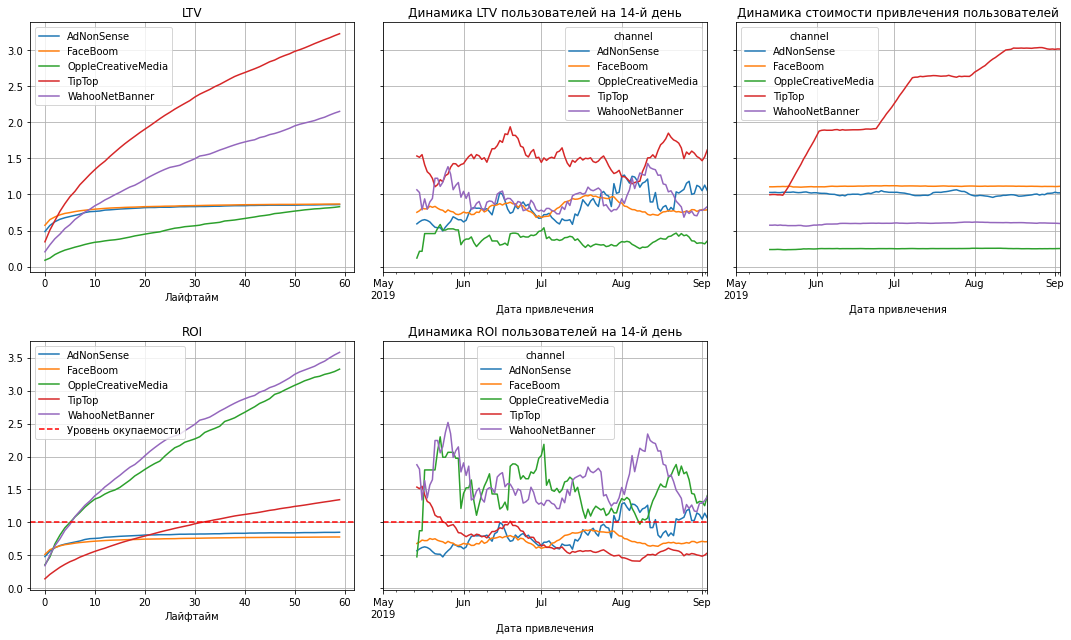

In [31]:
raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel in @head_chanels'),
    orders,
    observation_date,
    60,
    dimensions=['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Динамика ROI неумолима. Даже при горизонте в 60 дней, окупаемость падает до уровня в 0,5.

## Выводы

1. В рекламном бюджете большой перекос в сторону 2-х компаний TipTop и FaceBoom вместе они составляют 82,65% рекламного бюджета. Любые проблемы с этими каналами становятся проблемами всей компании.
1. Эти проблемы существуют - главные источники новых пользователей убыточны.
1. Проблема канала TipTop в том, что стоимость привлечения в нем слишком высокая, хоть остальные метрики и показывают прекрасные результаты, но это не перекрывает убытков.
1. Проблема канала FaceBoom в низком удержании пользователей. К 14-му дню компанию покидают практически все привлеченные клиенты.

###### Рекомендации:

1. Диверсификация. Эти каналы относятся к рынку США. Кроме них там есть MediaTornado, RocketSuperAds, YRabbit - прибыльные каналы, которым уделено печально мало внимания и денег. Особенно RocketSuperAds, который показал высокое качество привлеченных клиентов.
1. Уход от TipTop. Несмотря на прекрасные показатели иных метрик, стоимость привлечения клиентов в данный момент настолько высока, что даже высокое удержание и расчет LTV в несколько месяцев дают неутешительные прогнозы.
1. Т.к. TipTop привлекает большую часть клиентской базы, то отказ от сразу двух крупнейших рекламодателей может ударить по компании. FaceBoom убыточен только за счет низкого удержания, если есть способ его повысить, то канал перестанет быть убыточным.